In [58]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xarray as xr

In [59]:
#### Preprocecing ###

In [60]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [61]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [62]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [63]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]


In [64]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]


In [65]:
removed = recovered + death

In [66]:
### Data Preparation ###

In [67]:
S = confirmed.values
R = removed.values
L=5
repeat=10000
iter=2000

In [68]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L': L, 'S': S, 'R': R}

In [69]:
### Model ###

In [77]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79b0e816724d3a5e61dc0a5cbb84bf98 NOW.


In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter)

In [15]:
### Simulation and Visualization functions ###

In [16]:
T = S.shape[0]
N = S.shape[1]
epoch = pd.to_datetime('2020-01-22')

In [17]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizon):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    infected_list = [(confirmed - removed).loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    cumulative_list = [confirmed.loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    for d in range(horizon):
        r = c .* (1 - cumulative_list[-L] / p) + np.sqrt(sigma_r) * np.random.randn(N)
        I = infected_list[-L] @ r;
        cumulative = cumulative + I + np.sqrt(sigma_S) * np.random.randn(N);
        recovered = recovered + a * (cumulative[-1] - recovered[-1]) + np.sqrt(sigma_R) * np.random.randn(N);
        cumulative = cumulative + np.maximum(I, 0)
        recovered = np.maximum(recovered, 0)
        infected_list.append(cumulative - recovered)
        cumulative_list.append(cumulative)
        
    infected = pd.DataFrame(infected_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizon, freq='D'))
    cumulative = pd.DataFrame(cumulative_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizon, freq='D'))
    return infected, cumulative

In [ ]:
def monte_carlo(fit, start, horizon):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_b_s = fit['sigma_b']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    infected_list = []
    cumulative_list = []
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        I, C = simulate(a, p, c, sigma_b, sigma_S, sigma_R, start, horizon)
        I.index.name = 'Date'
        C.index.name = 'Date'
        infected_list.append(xarray.DataArray(I))
        cumulative_list.append(xarray.DataArray(C))
    infected = xarray.concat(infected_list, 'sim')
    cumulative = xarray.concat(cumulative_list, 'sim')
    return infected, cumulative

In [18]:
def draw_infected(infected, country):
    real = (confirmed - removed)[country]
    median = infected.median(dim='sim')
    upper = data.quantile(q=0.75, dim='sim')
    lower = data.quantile(q=0.25, dim='sim')
    graph['Real'] = real[country]
    graph['Median'] = median.loc({'Country/Region':country})
    graph['Upper'] = upper.loc({'Country/Region':country})
    graph['Lower'] = lower.loc({'Country/Region':country})
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2)

In [19]:
### Validation ###

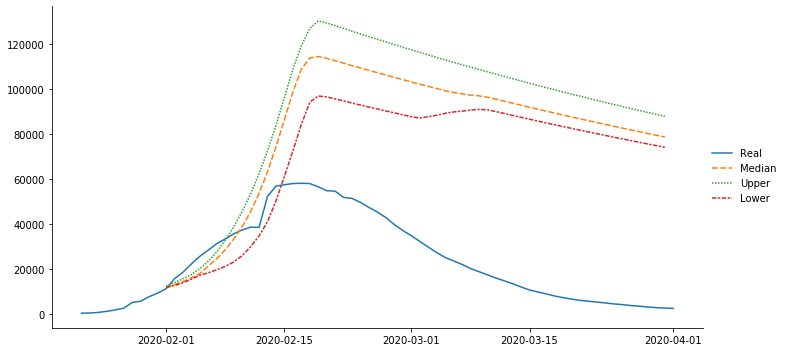

In [20]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

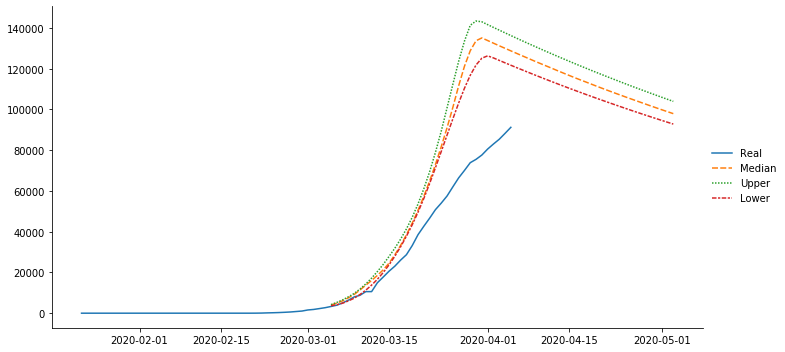

In [21]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

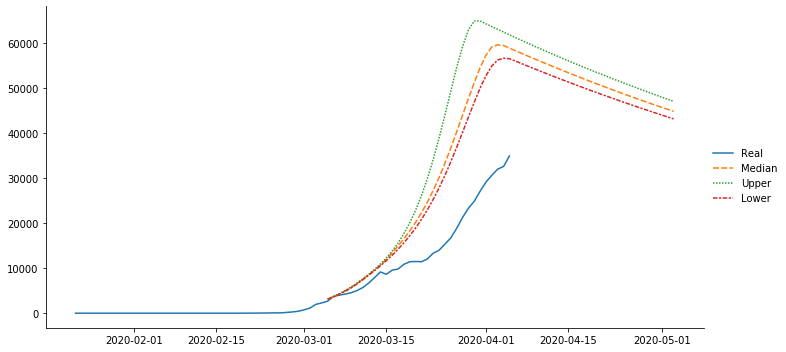

In [22]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

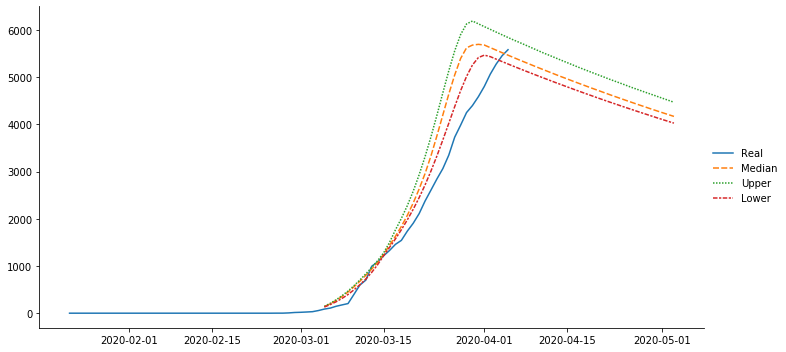

In [23]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

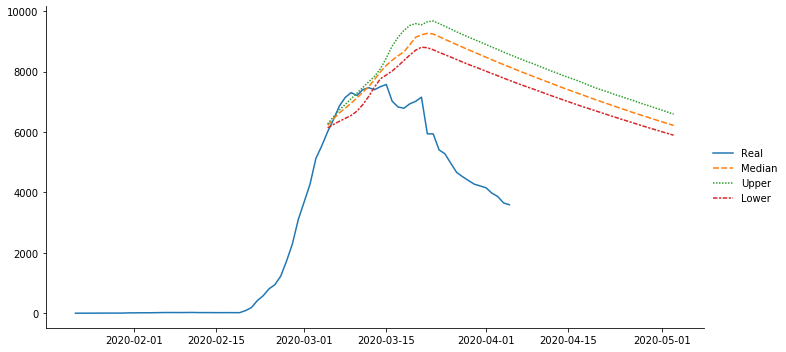

In [24]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

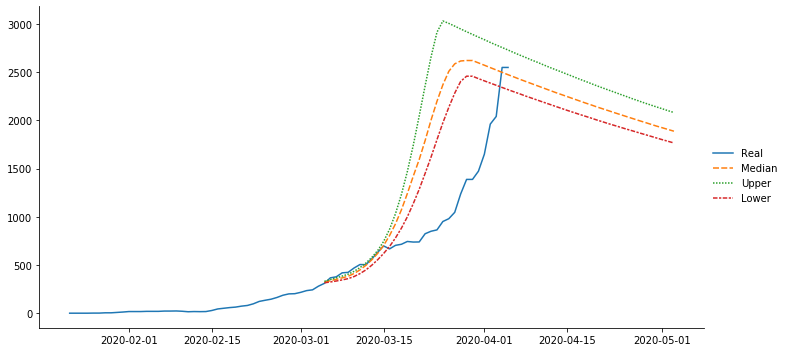

In [25]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

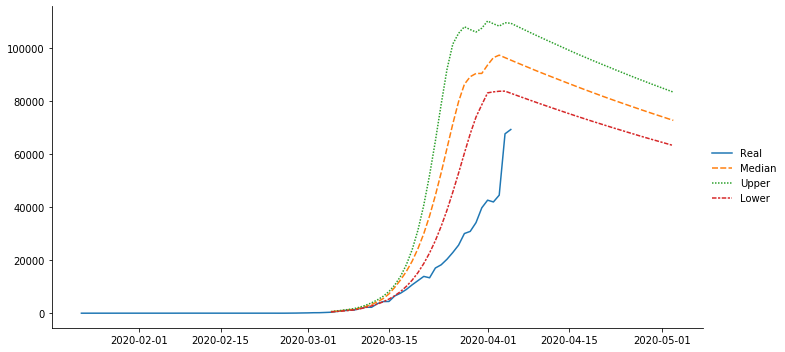

In [26]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

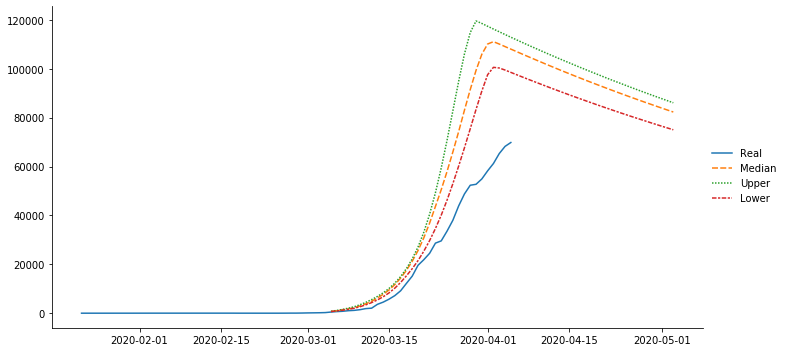

In [27]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

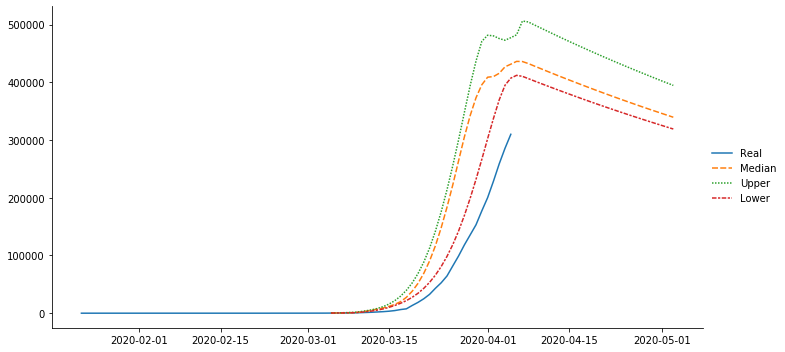

In [28]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [29]:
### Prediction ###

In [30]:
recent = confirmed.index[-1]


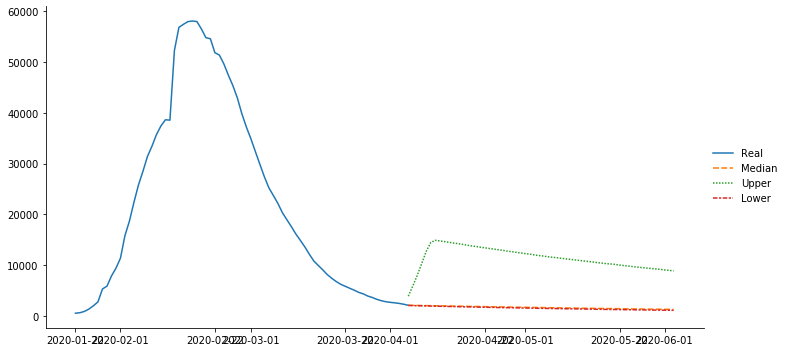

In [31]:
draw_infected(fit, recent, 60, 'China')

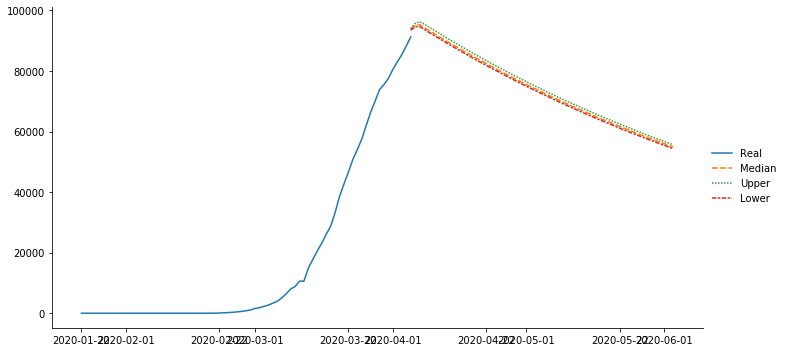

In [32]:
draw_infected(fit, recent, 60, 'Italy')

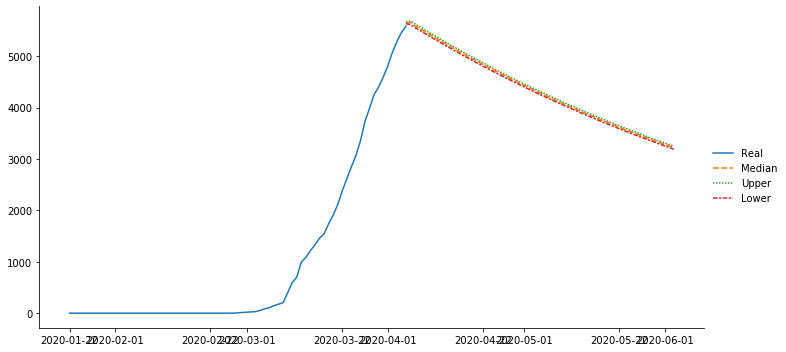

In [33]:
draw_infected(fit, recent, 60, 'Norway')

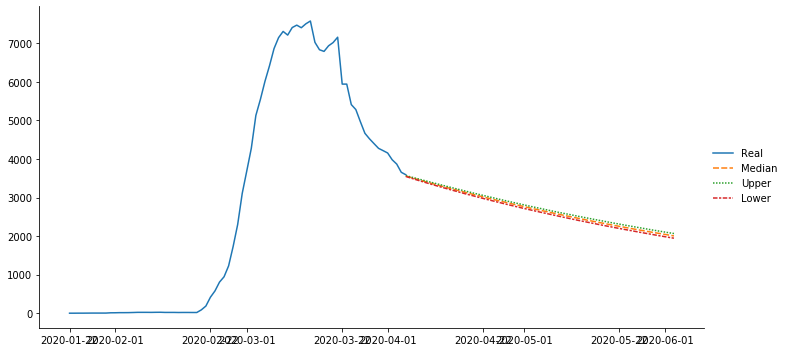

In [34]:
draw_infected(fit, recent, 60, 'Korea, South')

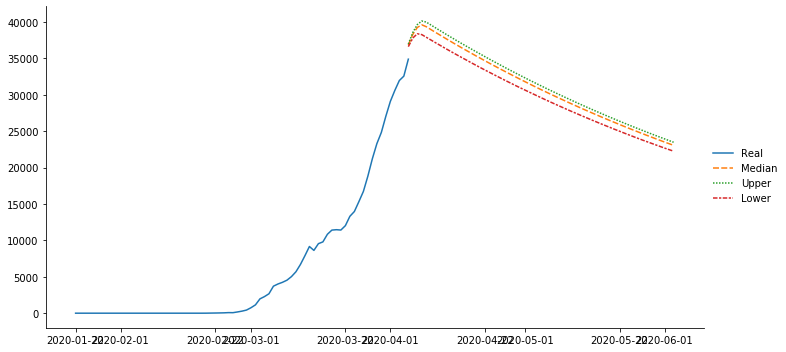

In [35]:
draw_infected(fit, recent, 60, 'Iran')

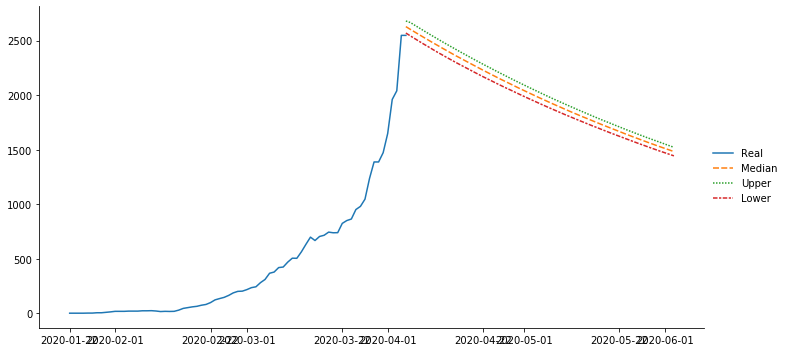

In [36]:
draw_infected(fit, recent, 60, 'Japan')

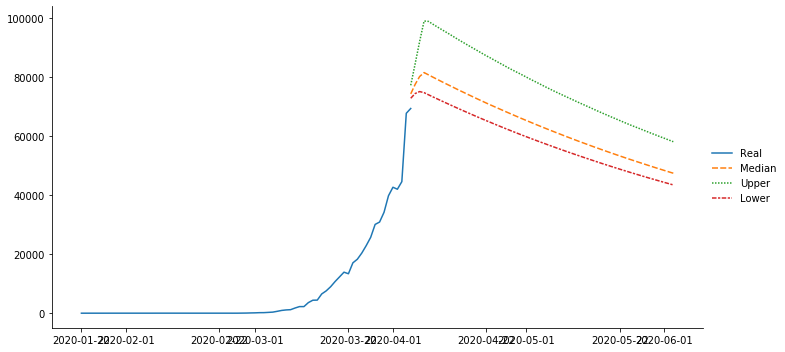

In [37]:
draw_infected(fit, recent, 60, 'France')

In [38]:
draw_infected(fit, recent, 60, 'Germany')

KeyboardInterrupt: 

In [ ]:
draw_infected(fit, recent, 60, 'US')

In [ ]:
def draw_infected_world(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    cum = []
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
        cum.append(cumulative.sum(axis=1).iloc[-1])
    cum = pd.Series(cum)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);
    print("Upper:{}, Median:{}, Lower:{}".format(cum.quantile(q=0.75), cum.median(), cum.quantile(q=0.25)))

In [ ]:
draw_infected_world(fit, recent, 365)

In [ ]:
draw_infected(fit, recent, 60, 'Spain')

In [ ]:
confirmed.columns

In [ ]:
pystan.check_hmc_diagnostics(fit)

In [ ]:
draw_infected(fit, recent, 60, 'United Kingdom')

In [ ]:
draw_infected(fit, recent, 60, 'Canada')

In [ ]:
draw_infected(fit, recent, 60, 'Malaysia')

In [ ]:
sns.distplot(fit['p'][:,confirmed.columns.get_loc('Japan')])


In [ ]:
n = confirmed.columns.get_loc('China')
sns.distplot(fit['c'][n,n])

In [ ]:
def draw_infected_sums(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(repeat):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        _, cumulative = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, cumulative.iloc[-1]], axis=1)
    melted = pd.melt(data.T).rename(columns={'value':'Infected'})
    my_order = melted.groupby(by=['Country/Region'])['Infected'].median().sort_values(ascending=False).index
    plt.figure(figsize=(10,20))
    sns.boxplot(data=melted, y = 'Country/Region', x='Infected', showfliers=False, order=my_order)
    table = pd.DataFrame({'Lower':data.quantile(q=0.25, axis=1), 
                           'Median':data.median(axis=1), 
                           'Upper':data.quantile(0.75, axis=1)})
    return table

In [ ]:
data = draw_infected_sums(fit, recent, 365)

In [ ]:
data

In [ ]:
draw_infected(fit, pd.to_datetime('2020-02-15'), 60, 'Korea, South')

In [ ]:
draw_infected(fit, pd.to_datetime('2020-03-01'), 60, 'Korea, South')

In [ ]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))

In [ ]:
df['Thailand']

In [ ]:
np.sqrt([1, 1, 1])

In [ ]:
np.sqrt([1, 1, 1]) * np.random.randn(3)

In [ ]:
draw_infected(fit, pd.to_datetime('2020-03-15'), 60, 'Turkey')